# Lab 2: Manipulator dynamics simulation

<div style="color: red;">

Pendientes lab2:
    
1. Graficar en Python
2. Explicar las gráficas
</div>

## Questions

### Question 1.1: Graphical representation

- What are the effects of modifying the dynamics parameters of the arm?

**ros2 bag record --all -o lab2bag1 -s mcap # base => m1=3, m2=2, l1=1, l2=0.6, b1=5, b2=5, g=9.81**

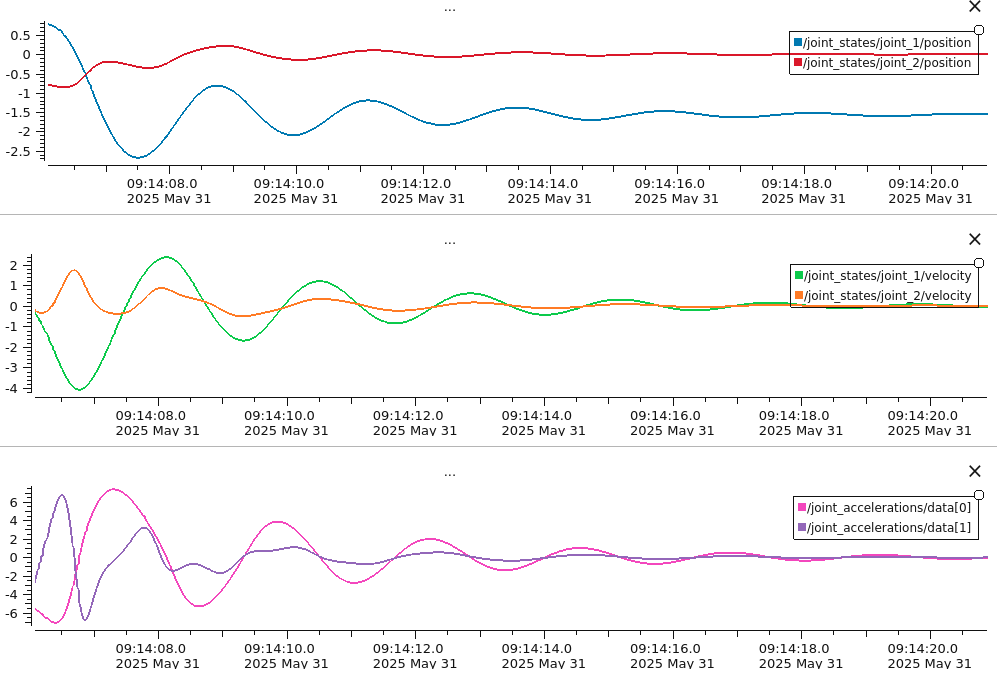

**ros2 bag record --all -o lab2bag2 -s mcap # base salvo m1=6**

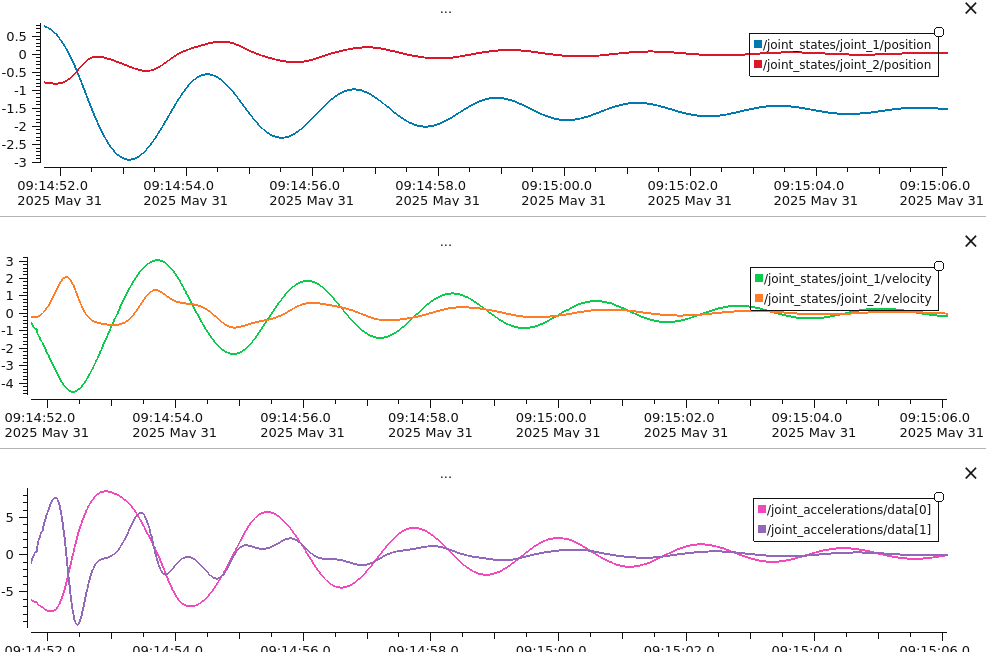

**ros2 bag record --all -o lab2bag3 -s mcap # base salvo m2=4**

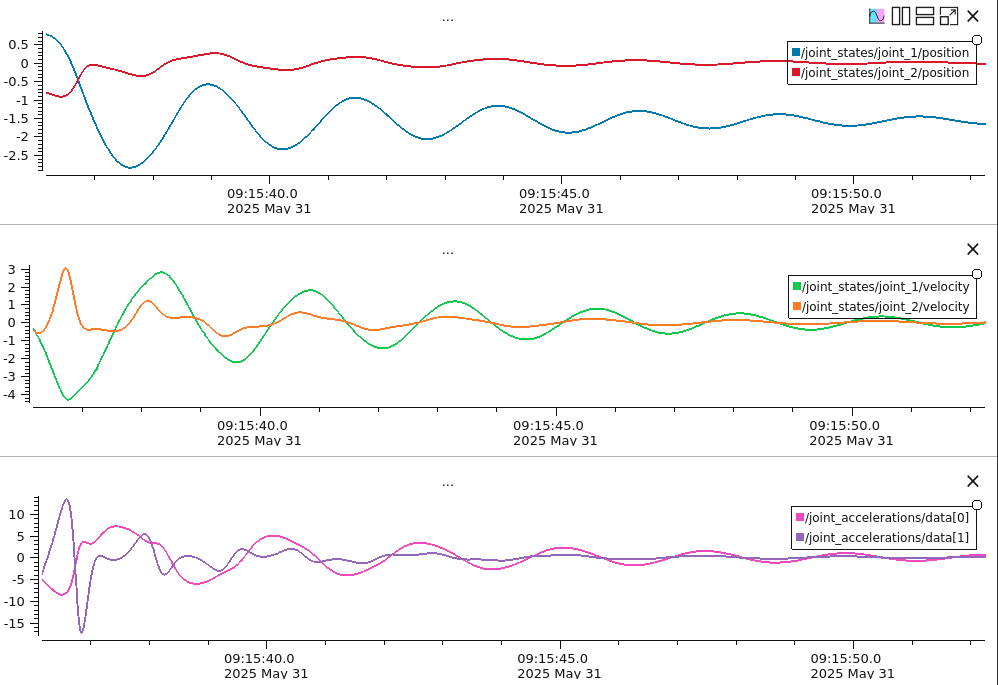

**ros2 bag record --all -o lab2bag4 -s mcap # base salvo L1=2**

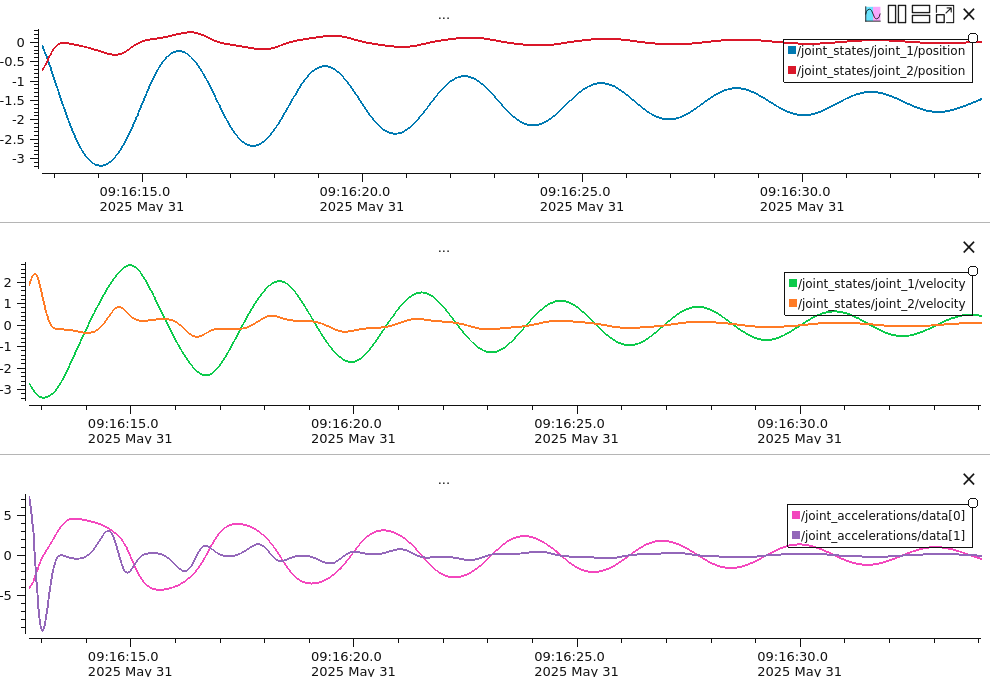

**ros2 bag record --all -o lab2bag5 -s mcap # base salvo L2=1.2**

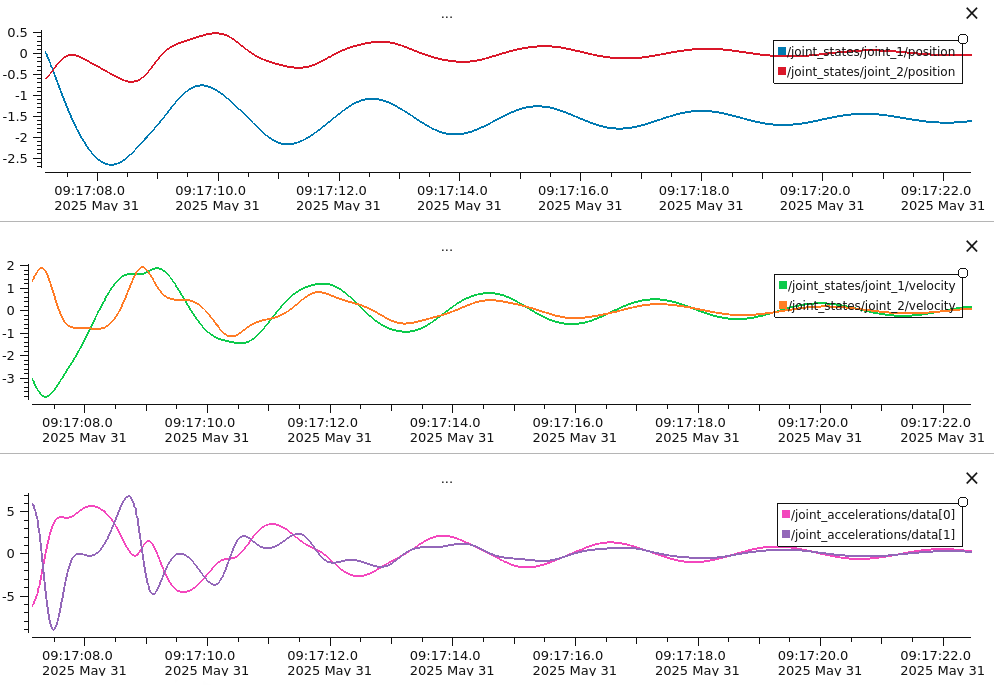

**ros2 bag record --all -o lab2bag6 -s mcap # lab26bag: base salvo b1=10**

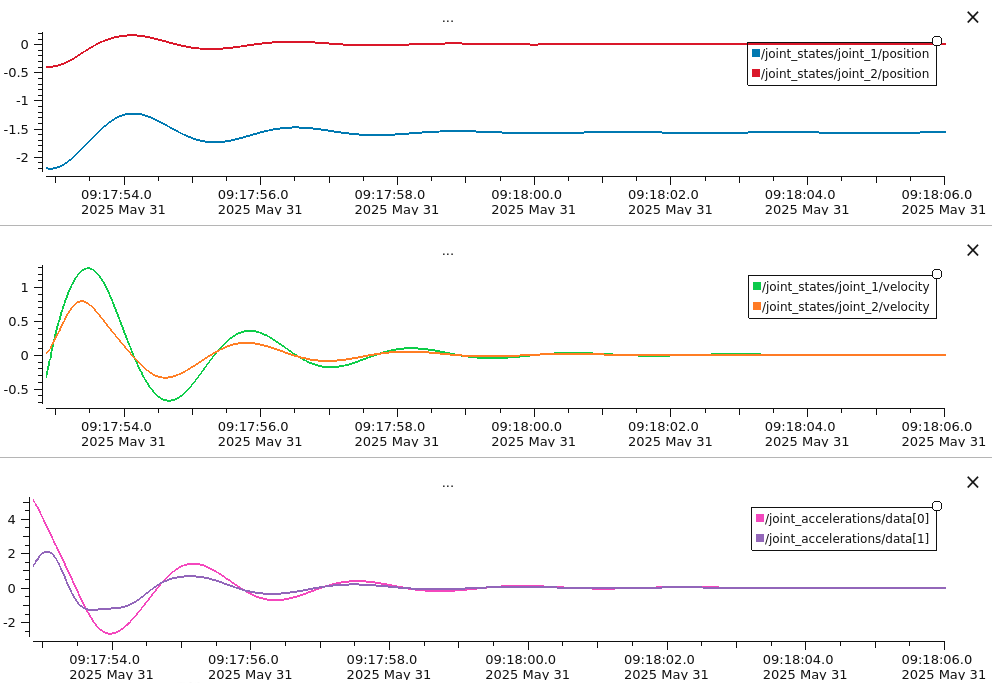


**ros2 bag record --all -o lab2bag7 -s mcap # lab27bag: base salvo b2=10**

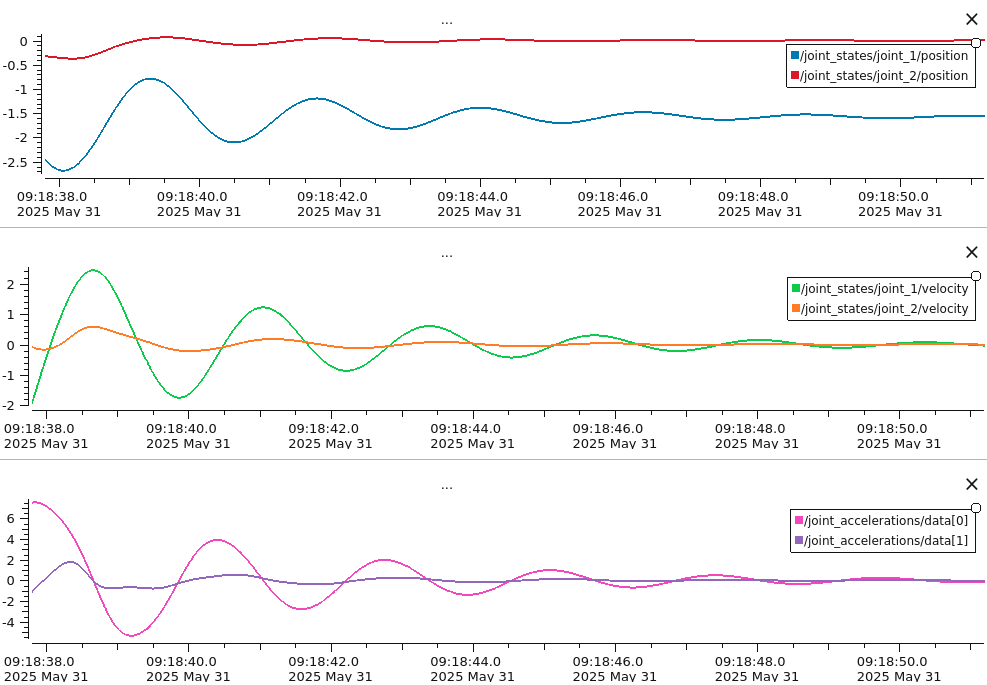

**ros2 bag record --all -o lab2bag8 -s mcap # lab28bag: base salvo g=19**

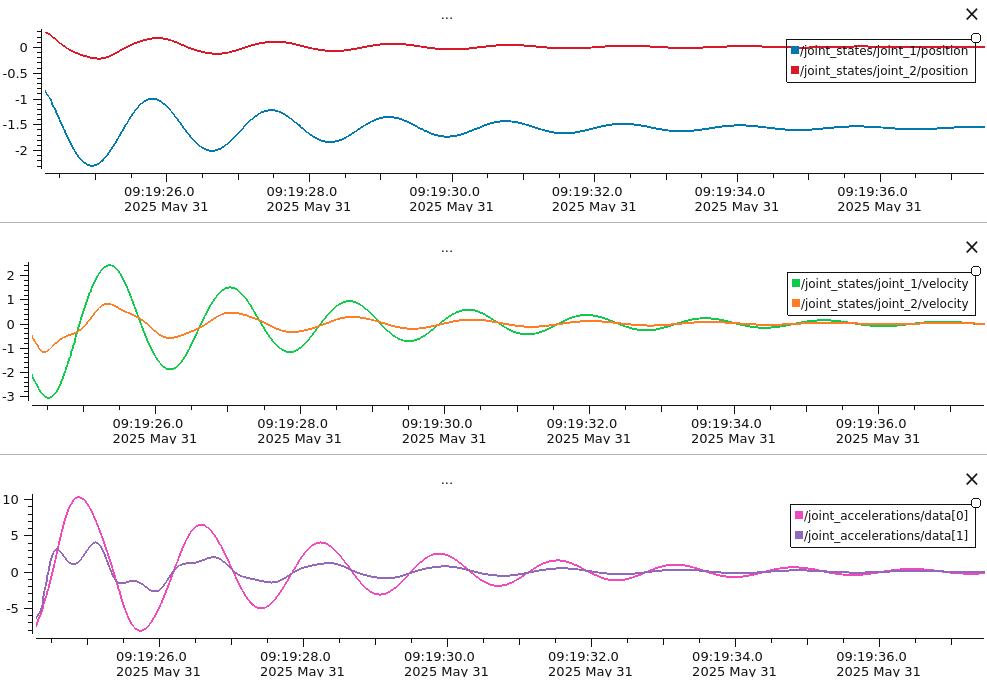



You can modify some of the following parameters inside the dynamics_params.yaml: m1, m2, b1, b2, and g. Run different experiments and plot the data to see the effects of those parameters.

Note that you only need to modify those inside uma_arm_dynamics.

## Setup ROS 2 Humble

1. Install the (uma_environment)[https://github.com/jmgandarias/uma_environment_tools]

```bash
wsl --install Ubuntu-22.04

cd
sudo apt update
sudo apt upgrade
git clone https://github.com/jmgandarias/uma_environment_tools.git
cd uma_environment_tools/scripts
./install_uma_environment.sh

update_uma_environment
```

2. Folder structure

```
│
├── uma_environment_tools
│       ├── config
│       ├── README.md
│       └── scripts
├── ros
│    ├── my_first_ros2_ws
|    │   ├── build
|    │   ├── install
|    │   ├── log
|    │   └── src
|    |
│    ├── my_second_ros2_ws
|    │   ├── build
|    │   ├── install
|    │   ├── log
|    │   └── src
|    |
│    └── ...
|       
├── log
│   ├── my_logged_data__YYYY_MM_DD__HH_MM_SS.mat
│   └── ...
│
└── .uma_params.env
```

## Install UMA manipulator package

```bash
cdw
cd src
git clone https://github.com/jmgandarias/uma_arm_description.git

sudo apt install ros-${ROS_DISTRO}-xacro
sudo apt install ros-${ROS_DISTRO}-gazebo-ros-pkgs
sudo  apt install ros-${ROS_DISTRO}-ros2-control ros-${ROS_DISTRO}-ros2-controllers ros-${ROS_DISTRO}-gazebo-ros2-control
sudo apt-get install -y ros-${ROS_DISTRO}-joint-state-publisher-gui ros-${ROS_DISTRO}-rviz2

sudo apt update
sudo apt upgrade

cdw
cb

# run RViz2
ros2 launch uma_arm_description uma_arm_visualization.launch.py

# run UI to move robot joints
ros2 run joint_state_publisher_gui joint_state_publisher_gui
```

## Simulate the robot dynamics

### Clone the uma_arm_control package

```
cdw
cd src
git clone https://github.com/jmgandarias/uma_arm_control.git

cdw
cb
```

### calculate_acceleration

```C++
// Method to calculate joint acceleration
    Eigen::VectorXd calculate_acceleration()
    {

        // Initialize M, C, Fb, g_vec, J, and tau_ext
        Eigen::MatrixXd M(2, 2);    // Inertia matrix
        Eigen::VectorXd C(2);       // Coriolis and centrifugal forces matrix
        Eigen::MatrixXd Fb(2, 2);   // Viscous friction matrix
        Eigen::VectorXd g_vec(2);   // gravity vector
        Eigen::MatrixXd J(2, 2);    //! jacobiano -> preguntar de donde sale
        Eigen::VectorXd tau_ext(2); // joint torques due to external forces

        // Initialize q1, q2, q_dot1, and q_dot2
        double q1 = joint_positions_(0);
        double q2 = joint_positions_(1);
        double q_dot1 = joint_velocities_(0);
        double q_dot2 = joint_velocities_(1);


        // Calculate matrix M
        M(0, 0) = m1_ * pow(l1_, 2) + m2_ * (pow(l1_, 2) + 2 * l1_ * l2_ * cos(q2) + pow(l2_, 2));
        M(0, 1) = m2_ * (l1_ * l2_ * cos(q2) + pow(l2_, 2));
        M(1, 0) = M(0, 1);
        M(1, 1) = m2_ * pow(l2_, 2);

        // Calculate vector C (C is 2x1 because it already includes q_dot)
        C << -m2_ * l1_ * l2_ * sin(q2) * (2 * q_dot1 * q_dot2 + pow(q_dot2, 2)),
              m2_ * l1_ * l2_ * pow(q_dot1, 2) * sin(q2);

        // Calculate Fb matrix
        Fb << b1_, 0.0,
              0.0, b2_;

        // Calculate g_vect
        g_vec << (m1_ + m2_) * l1_ * g_ * cos(q1) + m2_ * g_ * l2_ * cos(q1 + q2),
                    m2_      * l2_ * g_ * cos(q1 + q2);

        // Calculate J
        J << -l1_ * sin(q1) - l2_ * sin(q1 + q2), -l2_ * sin(q1 + q2),
              l1_ * cos(q1) + l2_ * cos(q1 + q2),  l2_ * cos(q1 + q2);

        // Calculate tau_ext
        tau_ext << J.transpose() * external_wrenches_;

        // Calculate joint accelerations using the dynamic model: q'' = M^(-1)[tau - C(q,q')q' - Fbq' - g(q) + tau_ext]
        Eigen::VectorXd q_ddot(2);
        q_ddot << M.inverse() * (joint_torques_ - C - Fb * joint_velocities_ - g_vec + tau_ext);
        
        // Return joint accelerations
        return q_ddot; // joint_accelerations_ = calculate_acceleration()
    }
```


### calculate_velocity (integrate acceleration)

```C++
    // Method to calculate joint velocity
    Eigen::VectorXd calculate_velocity()
    {
        // Integrate velocity over the time step (elapsed_time_)
        Eigen::VectorXd q_dot = joint_velocities_ + joint_accelerations_ * elapsed_time_;
        return q_dot; // joint_velocities_ = calculate_velocity();
    }
```

### calculate_position (integrate velocity)

```C++
    // Method to calculate joint position
    Eigen::VectorXd calculate_position()
    {
        // Integrate position over the time step (elapsed_time_)
        Eigen::VectorXd q = joint_positions_ + joint_velocities_ * elapsed_time_;
        return q; // joint_positions_ = calculate_position();
    }
```

## Launch the dynamics simulator node

```bash

cdw
cb
# run RViz2
ros2 launch uma_arm_description uma_arm_visualization.launch.py

# run simulation of behavior of robot
ros2 launch uma_arm_control uma_arm_dynamics_launch.py

# interaction between topics
rqt_graph

```

## Graphical representation

```bash

# Install plotjuggler
sudo apt update
#sudo apt install plotjuggler
sudo snap install plotjuggler-ros
sudo snap install plotjuggler
# Install mcap storage plugin !
cdw
mkdir experiments
sudo apt-get install ros-humble-rosbag2-storage-mcap

# record experiment
cdw
cd experiments
ros2 bag record --all -o lab2bag1 -s mcap # lab21bag: base => m1=3, m2=2, l1=1, l2=0.6, b1=5, b2=5, g=9.81


# launch experiment
ros2 launch uma_arm_description uma_arm_visualization.launch.py
ros2 launch uma_arm_control uma_arm_dynamics_launch.py

# launch plotjuggler

ros2 bag record -s mcap -a # Records all topics in MCAP format
# or
ros2 bag record -s mcap -o my_mcap_bag /my_topic_1 /my_topic_2


source /opt/ros/${ROS_DISTRO}/setup.bash
source ~/ros/advanced_robotics_ws/install/setup.bash
plotjuggler-ros
```

### Instalar plotjuggler

```bash
plotjuggler-ros
```